1. 데이터 로딩
2. 하이퍼파라미터 설정하기
3. 신경망 & 출력층 설계 및 구현
4. 미니배치 구성 & 학습
5. 기울기 (gradient) 계산
6. 가중치 업데이트
7. 학습 경과 기록하기 (loss function)

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

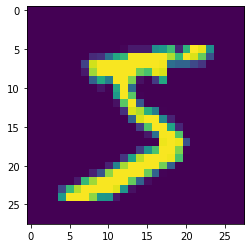

In [6]:
plt.imshow(x_train[0])

1. 데이터로딩

In [10]:
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
# 정규화과정, 픽셀의 이미지 표현범위가 0 ~ 255이므로 모두 0~1 의 값으로 만들기 위해
x_train,x_test = x_train/255.0,x_test/255.0
# 1차원 배열로 전환
x_test_flatten = x_test.reshape([x_test.shape[0],-1])
x_train_flatten = x_train.reshape([x_train.shape[0],-1])
print(x_test.shape)
print(x_test_flatten.shape)
t_train = y_train

(10000, 28, 28)
(10000, 784)


2층 신경망 클래스 정의

In [20]:
def sigmoid(x):
  return 1 / ( 1 + np.exp(-x))
def softmax(a):
  exp_a = np.exp(a)
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a
  return y
def cross_entropy_error(y,t):
  if y.ndim == 1: #1차원이면 2차원으로 만들어 주는 과정.
    t= t.reshape(1,t.size)
    y= y.reshape(1,y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size),t]+1e-7)) / batch_size

In [33]:
class TwoLayerNet:
  def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
    # 가중치 초기화
    self.params = {}
    self.params['w1'] = weight_init_std * np.random.randn(input_size,hidden_size)
    self.params['w2'] = weight_init_std * np.random.randn(hidden_size,output_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['b2'] = np.random.randn(output_size)

  def predict(self,x):
    w1,w2 = self.params['w1'],self.params['w2']
    b1,b2 = self.params['b1'], self.params['b2']
    
    a1 = np.dot(x,w1) + b1
    z1 = sigmoid(a1)
    
    a2 = np.dot(z1,w2) + b2
    y = softmax(a2)
    return y
  # 손실 함수,  x :입력데이터, t: 정답 데이터
  def loss(self,x,t):
    y = self.predict(x)
    loss = cross_entropy_error(y,t)
    return loss
  
  def accuracy(self,x,y):
    y = self.predict(x)
    y = np.argmax(y,axis=1) # 최대값을 불러옴
    t = np.argmax(t,axis=1)
    accuracy = np.sum(y==t) / float(x.shape[0])

    return accuracy

  def numerical_gradient(self,x,t):
    loss_w = lambda w:self.loss(x,t)

    grads = {}
    grads['w1'] = numerical_gradient(loss_w,self.params['w1'])
    grads['w2'] = numerical_gradient(loss_w,self.params['w2'])
    grads['b1'] = numerical_gradient(loss_w,self.params['b1'])
    grads['b2'] = numerical_gradient(loss_w,self.params['b2'])

    return grads

2. 하이퍼 파라미터 설정

In [34]:
iters_num = 10000 # 반복횟수
train_size = x_train_flatten.shape[0] # train data의 사이즈 10000
batch_size = 100 # 미니배치 크기.
learning_rate = 0.1 # 학습률 

3. 신경망 구현

In [35]:
def predict(network,x):
  w1,w2 = network['w1'],network['w2']
  b1,b2 = network['b1'],network['b2']

  # 입력층 -> 은닉층(1층,2층) -> 출력층
  a1 = np.dot(x,w1) + b1
  z1 = sigmoid(a1)
  a2 = np.dot(z1,w2) + b2
  # 분류문제이므로 soft max 함수를 사용한다.
  y = softmax(a2)
  return y

4. 미니배치 구성 & 학습
  - 


In [36]:
import numpy as np

In [37]:
def numerical_gradient1(f,x):
  h = 1e-4 # 0.0001
  grad = np.zeros_like(x) # x랑 모양이 똑같은데 0 으로 다 채워져 있는
  # 각 자리에 gradient 값을 저장하기 위해

  for idx in range(x.shape[0]):
    tmp_val = x[idx] # 원본값 저장

    #y증가량 / x증가량 = 기울기 
    # y증가량 : f(x+h) - f(x-h)
    # f(x+h)
    x[idx] = tmp_val + h
    fxh1 = f(x)
    # f(x-h)
    x[idx] = tmp_val -h 
    fxh2 = f(x)
    # gradient 값 저장.
    grad[idx] = (fxh1-fxh2) / (2*h)
    x[idx] = tmp_val
    
    return grad

In [38]:
# 네트워크 
network = TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

# 미니배치 구성

train_loss_list = []

# 학습할 땐 batch_size 만큼 뽑아서 사용
for i in range(iters_num):
  # 미니배치 구성
  batch_mask = np.random.choice(train_size,batch_size)
  # batch input
  x_batch = x_train_flatten[batch_mask]
  # 정답 label
  t_batch = t_train[batch_mask]

  # 기울기 계산
  grad = network.numerical_gradient(x_batch,t_batch)

  # 가중치 업데이트.
  for key in ('w1','w2','b1','b2'):
    network.params[key] -= learning_rate * grad[key]

  # 학습 경과 기록 (손실함수)

  loss = network.loss(x_batch,t_batch)
  train_loss_list.append(loss)
  print(loss)

TypeError: ignored